In [1]:
from AD_analysis import *
import Atmospheric_diffraction as atm_shift
import numpy as np
import matplotlib as mpl
import Integ_analysis as int_analysis

The code mainly draws on the following steps, with key variables described:

>analysis=AD_analysis()

This gets the class

====
>analysis.load_wave('LR','NIR','IY','H',sampling=1 * u.nm) 

This function loads the wavelengths that will be used for the shift calculations. 

First variable is LR or HR

Second variable is NIR or VIS

Third/fourth variables are the start/end bands. These can be the same, e.g. 'B', 'B'.

====
>analysis.load_airmasses(ZA_range=[0,10,20,30,40,50,60])

OR
>analysis.load_airmasses(HA_range=[0,1,2],targ_dec= 0 * u.degree)
This function loads the airmasses to calculate the shifts for.

Can use 1) zenith angles (ZA_range)
OR 2) hour angles (HA_range); the declination is -25.3 deg by default, change with targ_dec=X

====
>analysis.calculate_shifts(aperture_waveref = 1.1 * u.micron,reposition=True, guide_waveref=5 * u.micron)

This function calculates the shifts for the generated wavelengths and airmasses

aperture_waveref is the aperture wavelength reference for original position

guide_waveref is the telescope guiding wavelength reference

reposition = TRUE or FALSE is a setting that determines whether the aperture is aligned on the aperture wavelength reference for each sequential airmass

====
>analysis.calculate_transmissions(method="numerical moffat") 

This function calculates the transmissions for the shifts using one of several methods

method can be 1) analytical gaussian, 2) numerical gaussian, 3) numerical moffat, or 4) numerical durham

====

These functions can be used in many ways for different plots/analysis of transmissions/shifts

Most of these function have other optional variables, e.g., scale for the numerical simulations, whether to change FWHM with airmass and wavelength. These are described in the relevant function notes

In [2]:
#Following function is used to plot the described graphs
def shift_plot_v0(input,output,conditions):
        ZA_range=input['ZA_range']

        #1) wavelength vs displacement for different ZA
        centre_shift=atm_diff.diff_shift(input['aperture_waveref'],output['airmasses'][0],input['guide_waveref'],conditions)

        fig, ax = plt.subplots(figsize=(10,7))
        airmasses=atm_diff.zenith_dist_to_airmass(ZA_range)


        if input['reposition'] == False: #If repositioned, wavelength reference centre is meaningless as relative position changes
            plt.axhline(-centre_shift.value,linewidth=0.5,color='red', label='Wavelength Reference Centre')
        for i in range(0,len(output['airmasses'])):
            plt.plot(output['wavelengths'],output['shifts'][i],label="ZA = %2.2f deg, airmass = %2.2f" %(ZA_range[i],airmasses[i]))

        
        plt.legend(loc='best')
        ax.set_ylabel('Displacement from Guiding Wavelength (arcsec)')

        ax.set_xlabel('Wavelength (nm)')
        plt.title('AD Shifts, 0.64um to 1.8um, Guide Wavelength = 1.2um')
        ax.set_ybound(-0.8,0.2)

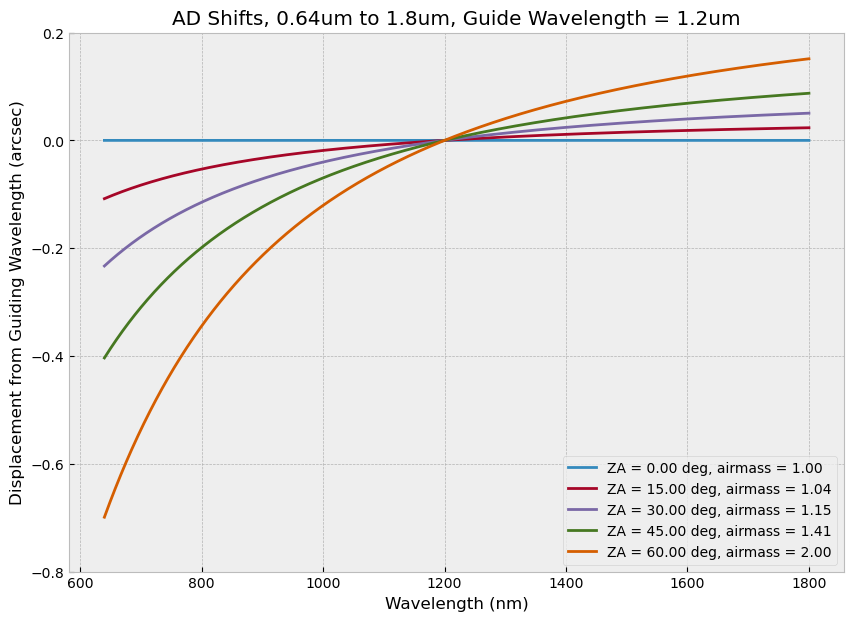

In [3]:
#Following is what is needed to plot the Wavelength vs Displacement and Displacement vs Airmass graphs. 
#Can switch out HA and ZA as needed in load_airmasses

analysis=AD_analysis() #Initialise class
# analysis.load_airmasses(HA_range=[0,1,2,3],targ_dec=10 * u.deg) #Generate airmasses (with HA)
analysis.load_airmasses(ZA_range=[0,15,30,45,60]) #Generate airmasses (with ZA)
analysis.output['wavelengths'] = np.arange(640,1800+1,1) * u.nm
analysis.calculate_shifts(aperture_waveref = 1.2 * u.micron,reposition=True,guide_waveref=1.2*u.micron,parallatic=False) #Calculates the shifts
shift_plot_v0(analysis.input,analysis.output,analysis.conditions) #Plot the graphs

In [4]:
#This function is used to calculate the average transmission over an integration.
#It takes the transmissions for each wavelength from multiple airmasses and averages them.
#This only is a true average of an integration if equally spaced HA have been used.
#This is not true with ZA, as ZA does not increase linearly with time
def observation_transmission(output):
    integ_transmission=[]
    for i in range(0,len(output['wavelengths'])):
        trans=0
        for o in range(0,len(output['transmissions'])):
            trans=trans+output['transmissions'][o][i]
        trans_mean=trans/len(output['transmissions'])
        integ_transmission.append(trans_mean)
    return integ_transmission

#Following function plots integration transmission average for single mode observations
def plot_integ_trans(aperture_centres,guide,analysis,parallatic=True):  
    """
    normalise: string, "none", "no ad"
        what to normalise the transmission to; either no normalisation, or relative to the no AD case (perfect ADC)

    """
    weights = np.arange(0, len(aperture_centres)+1)
    norm = mpl.colors.Normalize(vmin=min(weights), vmax=max(weights))
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.RdBu)

    integ_transmissions,opt_transmission=int_analysis.integ_trans(analysis,aperture_centres,guide,parallatic)
    
    plt.figure(figsize=[7,5])

    for count,i in enumerate(integ_transmissions):
        plt.plot(analysis.output['wavelengths'],np.array(i)/np.array(opt_transmission),label='Aperture Centre = {}'.format(aperture_centres[count]),color=cmap.to_rgba(len(aperture_centres)-count))
        print(int_analysis.integ_metric(np.array(i)/np.array(opt_transmission),"min trans"))
    plt.axhline(y=1,label='No AD Transmission',color='black',linestyle='--')
    plt.ylabel("Mean Transmission Relative to No AD")
    
    plt.legend()
    plt.title("Guiding = {}, HA {}-{}h, Dec = {}".format(guide,analysis.input['HA_range'][0],analysis.input['HA_range'][-1],analysis.input['targ_dec']))

    plt.ylim(0,1.1)
    plt.xlabel("Wavelength (nm)")
    
    

Target goes below Horizon above/below HA of +/- 5.9h
Best guide:
1.1 micron
Best aperture:
0.8 micron
Best metric:
0.909183523929168
====
0.909183523929168
0.909183523929168


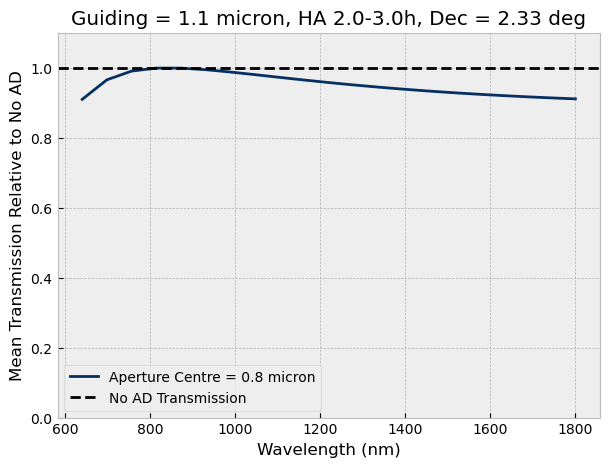

In [5]:
aperture_centres=[0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8]*u.micron

analysis=AD_analysis()
analysis.output['wavelengths']= np.arange(640,1800+1,58) * u.nm
analysis.output['aperture_diameter'] = 1.2 * u.arcsec
analysis.load_airmasses(HA_range=np.linspace(2,3,21),targ_dec=2.33*u.deg)
analysis.make_aperture("circle",method="numerical moffat",scale=0.1)

best_metric=0
best_guide=0
best_aperture=0
for guide in aperture_centres:
    integ_transmissions,opt_transmission=int_analysis.integ_trans(analysis,aperture_centres,guide,parallatic=True)
    for count,i in enumerate(integ_transmissions):
        current_metric=int_analysis.integ_metric(np.array(i)/np.array(opt_transmission),"min trans")
        if current_metric > best_metric:
            best_guide = guide
            best_metric=current_metric
            best_aperture=aperture_centres[count]
            
guide=best_guide
aperture_centres=[best_aperture]

integ_transmissions,opt_transmission=int_analysis.integ_trans(analysis,aperture_centres,guide,parallatic=True)
final_metric=int_analysis.integ_metric(np.array(integ_transmissions[0])/np.array(opt_transmission),"min trans")
print("Best guide:")
print(best_guide)
print("Best aperture:")
print(best_aperture)
print("Best metric:")
print(best_metric)
print("====")
print(final_metric)

guide=best_guide
aperture_centres=[best_aperture]
plot_integ_trans(aperture_centres,guide,analysis)




0.8817640867818746


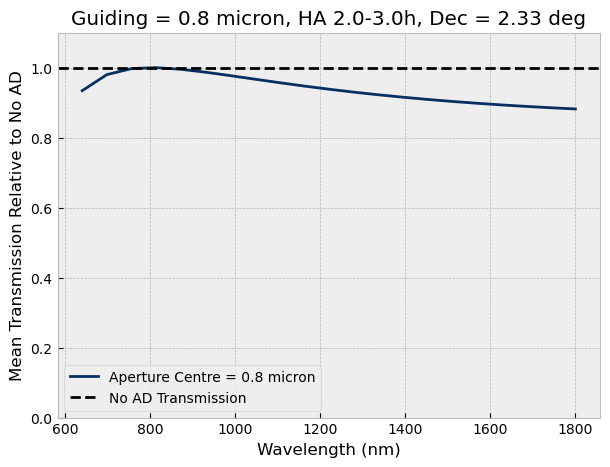

In [6]:
aperture_centres=[.8*u.micron]
guide=.8*u.micron
plot_integ_trans(aperture_centres,guide,analysis)


In [7]:
#Following function plots integration transmission average for single mode observations
def plot_integ_trans(aperture_centres,guide,analysis,parallatic=True,normalise="none"):  
    """
    normalise: string, "none", "no ad"
        what to normalise the transmission to; either no normalisation, or relative to the no AD case (perfect ADC)

    """
    weights = np.arange(0, len(aperture_centres)+1)
    norm = mpl.colors.Normalize(vmin=min(weights), vmax=max(weights))
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.RdBu)

    integ_transmissions,opt_transmission=int_analysis.integ_trans(analysis,aperture_centres,guide,parallatic)
    
    plt.figure(figsize=[7,5])

    for count,i in enumerate(integ_transmissions):
        plt.plot(analysis.output['wavelengths'],np.array(i)/np.array(opt_transmission),label='Aperture Centre = {}'.format(aperture_centres[count]),color=cmap.to_rgba(len(aperture_centres)-count))
        print(int_analysis.integ_metric(np.array(i)/np.array(opt_transmission),"min trans"))
    plt.axhline(y=1,label='No AD Transmission',color='black',linestyle='--')
    plt.ylabel("Mean Transmission Relative to No AD")
    
    plt.legend()
    plt.title("Guiding = {}, HA {}-{}h, Dec = {}".format(guide,analysis.input['HA_range'][0],analysis.input['HA_range'][-1],analysis.input['targ_dec']))

    plt.ylim(0,1.1)
    plt.xlabel("Wavelength (nm)")
    
    


Target goes below Horizon above/below HA of +/- 5.9h
0.9772094244093127
Target goes below Horizon above/below HA of +/- 5.9h
0.9792397400927498
Target goes below Horizon above/below HA of +/- 5.9h
0.9793535104440662
Target goes below Horizon above/below HA of +/- 5.9h
0.9595808788183869
Target goes below Horizon above/below HA of +/- 5.9h
0.9083292041829372


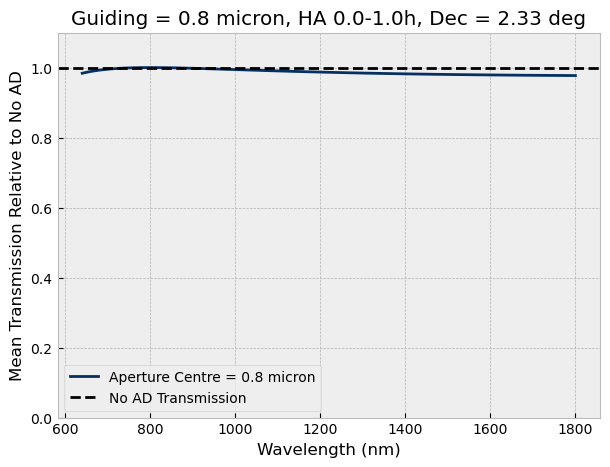

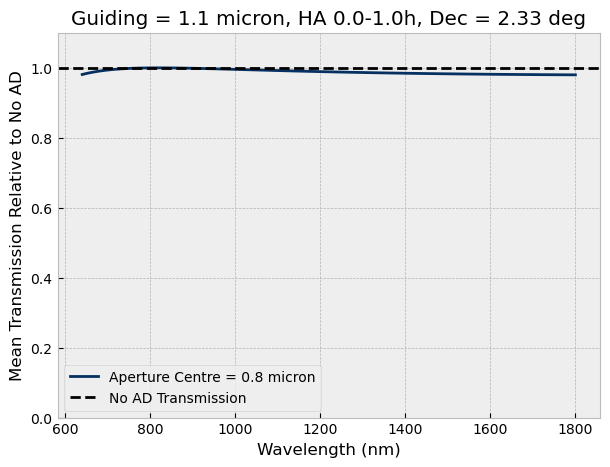

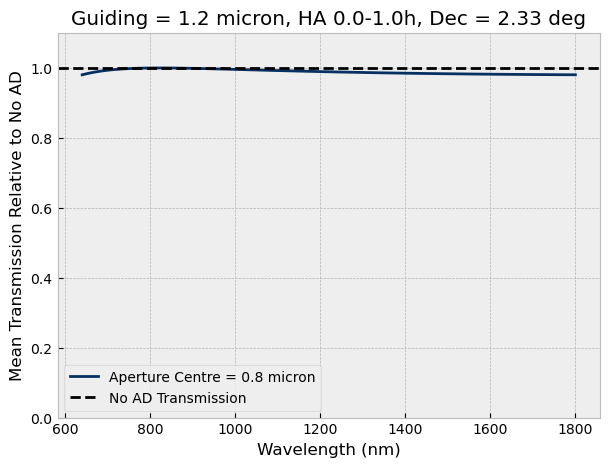

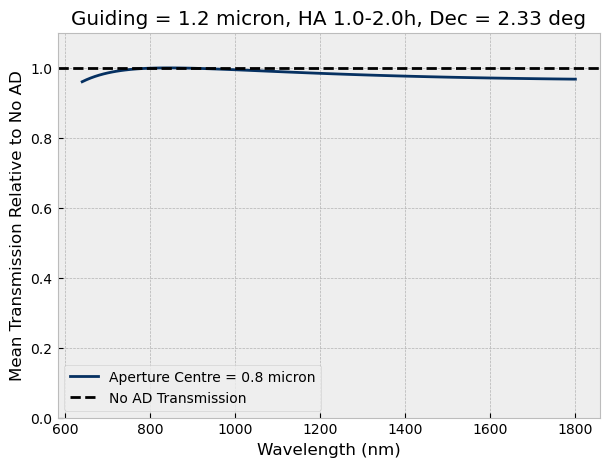

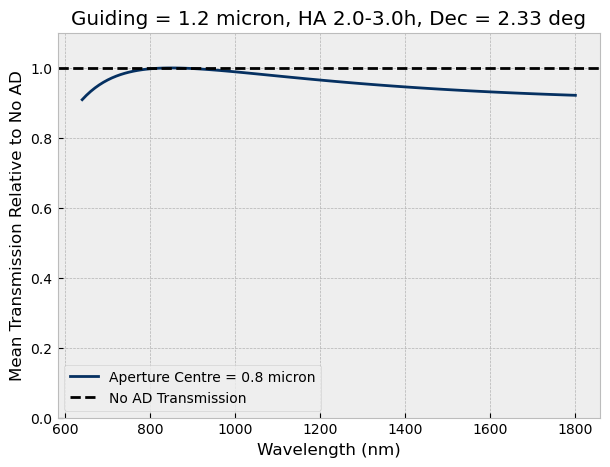

In [8]:
analysis=AD_analysis()
analysis.output['wavelengths']= np.arange(640,1800+1,10) * u.nm
analysis.output['aperture_diameter'] = 1.2 * u.arcsec
analysis.load_airmasses(HA_range=np.linspace(0,1,21),targ_dec=2.33*u.deg)
analysis.make_aperture("circle",method="numerical moffat")
aperture_centres=[.8*u.micron]
guide=.8*u.micron
plot_integ_trans(aperture_centres,guide,analysis)
airmass1=analysis.output['airmasses']

analysis=AD_analysis()
analysis.output['wavelengths']= np.arange(640,1800+1,10) * u.nm
analysis.output['aperture_diameter'] = 1.2 * u.arcsec
analysis.load_airmasses(HA_range=np.linspace(0,1,21),targ_dec=2.33*u.deg)
analysis.make_aperture("circle",method="numerical moffat")
aperture_centres=[.8*u.micron]
guide=1.1*u.micron
plot_integ_trans(aperture_centres,guide,analysis)
airmass1=analysis.output['airmasses']

analysis=AD_analysis()
analysis.output['wavelengths']= np.arange(640,1800+1,10) * u.nm
analysis.output['aperture_diameter'] = 1.2 * u.arcsec
analysis.load_airmasses(HA_range=np.linspace(0,1,21),targ_dec=2.33*u.deg)
analysis.make_aperture("circle",method="numerical moffat")
aperture_centres=[.8*u.micron]
guide=1.2*u.micron
plot_integ_trans(aperture_centres,guide,analysis)
airmass1=analysis.output['airmasses']



analysis=AD_analysis()
analysis.output['wavelengths']= np.arange(640,1800+1,10) * u.nm
analysis.output['aperture_diameter'] = 1.2 * u.arcsec
analysis.load_airmasses(HA_range=np.linspace(1,2,21),targ_dec=2.33*u.deg)
analysis.make_aperture("circle",method="numerical moffat")
airmass2=analysis.output['airmasses']

plot_integ_trans(aperture_centres,guide,analysis)


analysis=AD_analysis()
analysis.output['wavelengths']= np.arange(640,1800+1,10) * u.nm
analysis.output['aperture_diameter'] = 1.2 * u.arcsec
analysis.load_airmasses(HA_range=np.linspace(2,3,21),targ_dec=2.33*u.deg)
analysis.make_aperture("circle",method="numerical moffat")
airmass3=analysis.output['airmasses']
plot_integ_trans(aperture_centres,guide,analysis)


(0.0, 1.1)

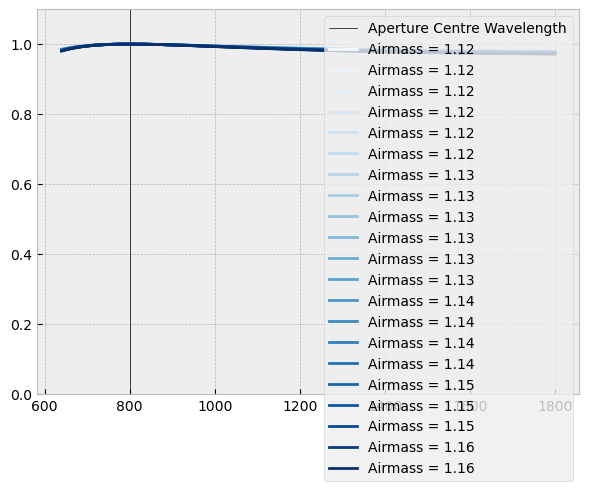

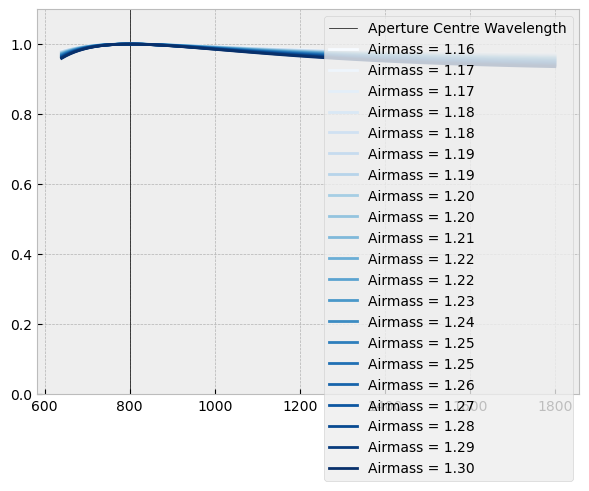

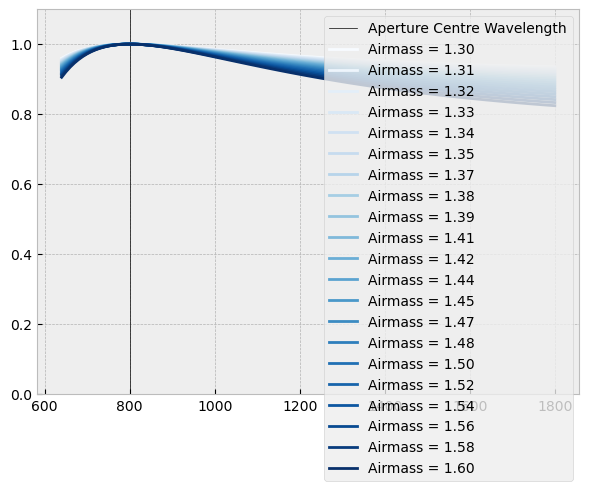

In [9]:
analysis=AD_analysis()
analysis.output['wavelengths']= np.arange(640,1800+1,10) * u.nm
analysis.output['aperture_diameter'] = 1.2 * u.arcsec
analysis.load_airmasses(airmasses=airmass1)
analysis.calculate_shifts(aperture_waveref = 0.8 * u.micron,reposition=True, guide_waveref=0.8 * u.micron)
analysis.make_aperture("circle",method="numerical moffat")
analysis.calculate_transmissions()
fig, ax = plt.subplots(figsize=(7,5))
wavelengths=analysis.output['wavelengths']
transmissions=analysis.output['transmissions']
weights = np.arange(1, len(analysis.output['airmasses'])+1)
norm = mpl.colors.Normalize(vmin=min(weights), vmax=max(weights))
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
plt.axvline(0.8*1000,color='black',linewidth=0.5,label='Aperture Centre Wavelength')
for i in range(0,len(analysis.output['shifts'])):
    for o in range(0,len(analysis.output['shifts'][i])):
        analysis.output['shifts'][i][o]=0      
analysis.calculate_transmissions()
for i in range(0,len(transmissions)):
    plt.plot(wavelengths,np.array(transmissions[i])/np.array(analysis.output['transmissions'][i]),color=cmap.to_rgba(i+1),label="Airmass = %2.2f" %(analysis.output['airmasses'][i]),linestyle='-')    
plt.legend()
plt.ylim(0,1.1)

analysis=AD_analysis()
analysis.output['wavelengths']= np.arange(640,1800+1,10) * u.nm
analysis.output['aperture_diameter'] = 1.2 * u.arcsec
analysis.load_airmasses(airmasses=airmass2)
analysis.calculate_shifts(aperture_waveref = 0.8 * u.micron,reposition=True, guide_waveref=0.8 * u.micron)
analysis.make_aperture("circle",method="numerical moffat")
analysis.calculate_transmissions()
fig, ax = plt.subplots(figsize=(7,5))
wavelengths=analysis.output['wavelengths']
transmissions=analysis.output['transmissions']
weights = np.arange(1, len(analysis.output['airmasses'])+1)
norm = mpl.colors.Normalize(vmin=min(weights), vmax=max(weights))
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
plt.axvline(0.8*1000,color='black',linewidth=0.5,label='Aperture Centre Wavelength')
for i in range(0,len(analysis.output['shifts'])):
    for o in range(0,len(analysis.output['shifts'][i])):
        analysis.output['shifts'][i][o]=0      
analysis.calculate_transmissions()
for i in range(0,len(transmissions)):
    plt.plot(wavelengths,np.array(transmissions[i])/np.array(analysis.output['transmissions'][i]),color=cmap.to_rgba(i+1),label="Airmass = %2.2f" %(analysis.output['airmasses'][i]),linestyle='-')    
plt.legend()
plt.ylim(0,1.1)

analysis=AD_analysis()
analysis.output['wavelengths']= np.arange(640,1800+1,10) * u.nm
analysis.output['aperture_diameter'] = 1.2 * u.arcsec
analysis.load_airmasses(airmasses=airmass3)
analysis.calculate_shifts(aperture_waveref = 0.8 * u.micron,reposition=True, guide_waveref=0.8 * u.micron)
analysis.make_aperture("circle",method="numerical moffat")
analysis.calculate_transmissions()
fig, ax = plt.subplots(figsize=(7,5))
wavelengths=analysis.output['wavelengths']
transmissions=analysis.output['transmissions']
weights = np.arange(1, len(analysis.output['airmasses'])+1)
norm = mpl.colors.Normalize(vmin=min(weights), vmax=max(weights))
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
plt.axvline(0.8*1000,color='black',linewidth=0.5,label='Aperture Centre Wavelength')
for i in range(0,len(analysis.output['shifts'])):
    for o in range(0,len(analysis.output['shifts'][i])):
        analysis.output['shifts'][i][o]=0      
analysis.calculate_transmissions()
for i in range(0,len(transmissions)):
    plt.plot(wavelengths,np.array(transmissions[i])/np.array(analysis.output['transmissions'][i]),color=cmap.to_rgba(i+1),label="Airmass = %2.2f" %(analysis.output['airmasses'][i]),linestyle='-')    
plt.legend()
plt.ylim(0,1.1)